In [1]:
import os
import gc
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from pyInfinityFlow.InfinityFlow_Utilities import move_features_to_silent
from pyInfinityFlow.InfinityFlow_Utilities import anndata_to_df
from pyInfinityFlow.InfinityFlow_Utilities import read_fcs_into_anndata
from pyInfinityFlow.InfinityFlow_Utilities import apply_logicle_to_anndata
from pyInfinityFlow.fcs_io import FCSFileObject

os.chdir("/Volumes/salomonis2/LabFiles/Kyle/Analysis/2022_12_07_new_multilin_panel/")

In [2]:
path_fcs_data = "output/automated_py3_cellharmony_r7/fcs/"

tmp_fcs = read_fcs_into_anndata(os.path.join(\
    path_fcs_data,
    "infinity_flow_r7_labels_added_redo.fcs"))

tmp_fcs.var.loc[["r7_number", "r7_rho"], "USE_LOGICLE"] = False


In [3]:
map_cluster_num = pd.read_csv(os.path.join(\
        path_fcs_data,
        "r7_to_number_cluster_mapping_redo.csv"),
    header=None)

map_cluster_num.columns = ["r7", "number"]

map_cluster_num

,r7,number
0,B-cell progenitor,1
1,BMCP,2
2,Baso,3
3,Bcl11b+_preETP_Cd3d,4
4,Bcl11b+_preETP_Tdrd5,5
...,...,...
83,preNeu-3-Mac_C1qa,84
84,preNeu-Ebf1,85
85,proNeu-1,86
86,proNeu-1-ADT,87


In [4]:
tmp_fcs.obs["r7_num"] = tmp_fcs[:,"r7_number"].X.toarray(\
    ).reshape(-1).astype(int)

tmp_map = pd.Series(\
    map_cluster_num["r7"].values, 
    index = map_cluster_num["number"].values)

tmp_fcs.obs["r7"] = [tmp_map[i] for i in tmp_fcs.obs["r7_num"].values]

In [5]:
# Sample evenly from r7 cluster definitions
sorted_vcounts = tmp_fcs.obs["r7"].value_counts().sort_values()

target_final_n = int(1e5)
n_groups = len(sorted_vcounts)
tmp_remainder = target_final_n
sampled_cells = []
for tmp_cluster in sorted_vcounts.index.values:
    target_sample_number = round(tmp_remainder / n_groups)
    seg_cells = tmp_fcs.obs.loc[tmp_fcs.obs["r7"] == tmp_cluster].copy()
    
    if seg_cells.shape[0] > target_sample_number:
        sampled_cells.append(\
            seg_cells.sample(target_sample_number).index.values)
        tmp_remainder -= target_sample_number
    else:
        sampled_cells.append(seg_cells.index.values)
        tmp_remainder -= seg_cells.shape[0]

    n_groups -= 1


sampled_cells = np.concatenate(sampled_cells)

In [6]:
features_to_use = tmp_fcs.var.loc[\
    (~tmp_fcs.var["name"].str.startswith("Imputed_")) & \
    (tmp_fcs.var["name"] != "") & \
    (tmp_fcs.var["name"] != "DEAD")].index.values

features_to_use

array(['APC-A', 'APC-Cy7-A', 'AlexaFluor647-A', 'AlexaFluor700-A',
       'BUV395-A', 'BUV615-A', 'BUV737-A', 'BUV805-A', 'BV421-A',
       'BV480-A', 'BV510-A', 'BV570-A', 'BV605-A', 'BV650-A', 'BV711-A',
       'BV750-A', 'BV785-A', 'GFP-A', 'PE-A', 'PE-Cy5-A', 'PE-Cy5.5-A',
       'PE-Cy7-A', 'PacificBlue-A', 'PerCP-Cy5.5-A', 'PerCP-eFluor710-A'],
      dtype=object)

In [7]:
print("Applying logicle normalization...")
apply_logicle_to_anndata(tmp_fcs)

Applying logicle normalization...


In [8]:
# Calculate UMAP based on evenly sampled R7 clusters
import umap
umap_model = umap.UMAP(\
    verbose=True, 
    n_components=2,
    min_dist=0.5,
    n_neighbors=50,
    n_epochs=200)

umap_model.fit(\
    tmp_fcs[sampled_cells,features_to_use].X.toarray())
umap_coors = umap_model.transform(\
    tmp_fcs[:,features_to_use].X.toarray())

tmp_fcs.obs[["umap-x", "umap-y"]] = umap_coors

/Users/fero3l/opt/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP(min_dist=0.5, n_epochs=200, n_neighbors=50, verbose=True)
Thu May 18 13:17:42 2023 Construct fuzzy simplicial set
Thu May 18 13:17:42 2023 Finding Nearest Neighbors
Thu May 18 13:17:42 2023 Building RP forest with 21 trees
Thu May 18 13:17:42 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Thu May 18 13:17:59 2023 Finished Nearest Neighbor Search
Thu May 18 13:18:03 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:32]


Thu May 18 13:18:43 2023 Finished embedding
Thu May 18 13:18:51 2023 Worst tree score: 0.95993000
Thu May 18 13:18:51 2023 Mean tree score: 0.96204095
Thu May 18 13:18:51 2023 Best tree score: 0.96378000
Thu May 18 13:18:53 2023 Forward diversification reduced edges from 5000000 to 916808
Thu May 18 13:18:55 2023 Reverse diversification reduced edges from 916808 to 916808
Thu May 18 13:18:57 2023 Degree pruning reduced edges from 1076018 to 1076018
Thu May 18 13:18:57 2023 Resorting data and graph based on tree order
Thu May 18 13:18:57 2023 Building and compiling search function


Epochs completed: 100%| ██████████ 66/66 [01:53]


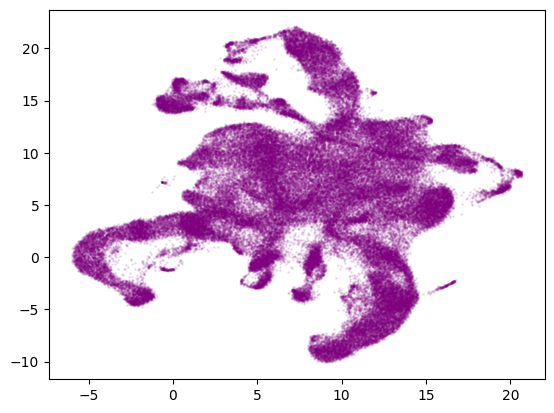

In [9]:
plt.scatter(\
    tmp_fcs[sampled_cells,:].obs["umap-x"].values,
    tmp_fcs[sampled_cells,:].obs["umap-y"].values,
    s=1,
    alpha=0.1,
    color="purple")


In [10]:
umap_model_3d = umap.UMAP(\
    verbose=True, 
    n_components=3,
    min_dist=0.5,
    n_neighbors=50,
    n_epochs=200)

umap_model_3d.fit(\
    tmp_fcs[sampled_cells,features_to_use].X.toarray())
umap_coors_3d = umap_model_3d.transform(\
    tmp_fcs[:,features_to_use].X.toarray())

tmp_fcs.obs[["umap_3d-x", "umap_3d-y", "umap_3d-z"]] = umap_coors_3d

UMAP(min_dist=0.5, n_components=3, n_epochs=200, n_neighbors=50, verbose=True)
Thu May 18 14:41:41 2023 Construct fuzzy simplicial set
Thu May 18 14:41:41 2023 Finding Nearest Neighbors
Thu May 18 14:41:41 2023 Building RP forest with 21 trees
Thu May 18 14:41:41 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Thu May 18 14:41:47 2023 Finished Nearest Neighbor Search
Thu May 18 14:41:49 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:33]


Thu May 18 14:42:29 2023 Finished embedding
Thu May 18 14:42:37 2023 Worst tree score: 0.96048000
Thu May 18 14:42:37 2023 Mean tree score: 0.96278286
Thu May 18 14:42:37 2023 Best tree score: 0.96464000
Thu May 18 14:42:37 2023 Forward diversification reduced edges from 5000000 to 916818
Thu May 18 14:42:37 2023 Reverse diversification reduced edges from 916818 to 916818
Thu May 18 14:42:37 2023 Degree pruning reduced edges from 1076046 to 1076046
Thu May 18 14:42:37 2023 Resorting data and graph based on tree order
Thu May 18 14:42:37 2023 Building and compiling search function


Epochs completed: 100%| ██████████ 66/66 [01:50]


In [11]:
umap_coors_3d

array([[ 9.815159  , -0.73796946,  7.7842937 ],
       [10.540523  ,  7.9517913 ,  0.40318555],
       [10.117249  , -1.9557695 ,  3.5055315 ],
       ...,
       [10.384539  ,  5.4923306 ,  1.4001667 ],
       [ 6.4747734 , -0.24514216, -3.649446  ],
       [12.904038  ,  5.9806128 ,  3.23143   ]], dtype=float32)

In [12]:
tmp_fcs.obs[["umap-x", "umap-y"]].to_csv(\
    "output/automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "umap_2d_coordinates_redo.csv",
    header=True, index=True, index_label="cell_id")

In [13]:
tmp_fcs.obs[["umap_3d-x", "umap_3d-y", "umap_3d-z"]].to_csv(\
    "output/automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "umap_3d_coordinates_redo.csv",
    header=True, index=True, index_label="cell_id")

In [15]:
pd.Series(sampled_cells).to_csv("output/automated_py3_cellharmony_r7/"\
    "evenly_sampled_r7/list_evenly_sampled_cells_redo.csv",
    header=False, index=False)

In [37]:
# tmp_fcs.var.loc[features_to_use]

,name,USE_LOGICLE,LOGICLE_T,LOGICLE_W,LOGICLE_M,LOGICLE_A,LOGICLE_APPLIED,IMPUTED
APC-A,CD371,True,3000000.0,0.0,3.0,1.0,True,False
APC-Cy7-A,CD48,True,3000000.0,0.0,3.0,1.0,True,False
AlexaFluor647-A,CD55,True,3000000.0,0.0,3.0,1.0,True,False
AlexaFluor700-A,Ly6G,True,3000000.0,0.0,3.0,1.0,True,False
BUV395-A,CD16_32,True,3000000.0,0.0,3.0,1.0,True,False
BUV615-A,ITGB7,True,3000000.0,0.0,3.0,1.0,True,False
BUV737-A,CD27,True,3000000.0,0.0,3.0,1.0,True,False
BUV805-A,CD105,True,3000000.0,0.0,3.0,1.0,True,False
BV421-A,CD131,True,3000000.0,0.0,3.0,1.0,True,False
BV480-A,CD93,True,3000000.0,0.0,3.0,1.0,True,False


In [55]:
# print(tmp_fcs.var.to_string())

                                            name  USE_LOGICLE  LOGICLE_T  LOGICLE_W  LOGICLE_M  LOGICLE_A  LOGICLE_APPLIED  IMPUTED
APC-A                                      CD371         True  3000000.0        0.0        3.0        1.0             True    False
APC-Cy7-A                                   CD48         True  3000000.0        0.0        3.0        1.0             True    False
AlexaFluor647-A                             CD55         True  3000000.0        0.0        3.0        1.0             True    False
AlexaFluor700-A                             Ly6G         True  3000000.0        0.0        3.0        1.0             True    False
BUV395-A                                 CD16_32         True  3000000.0        0.0        3.0        1.0             True    False
BUV615-A                                   ITGB7         True  3000000.0        0.0        3.0        1.0             True    False
BUV737-A                                    CD27         True  3000000.0    

Text(0.5, 1.0, 'Marker IL33r')

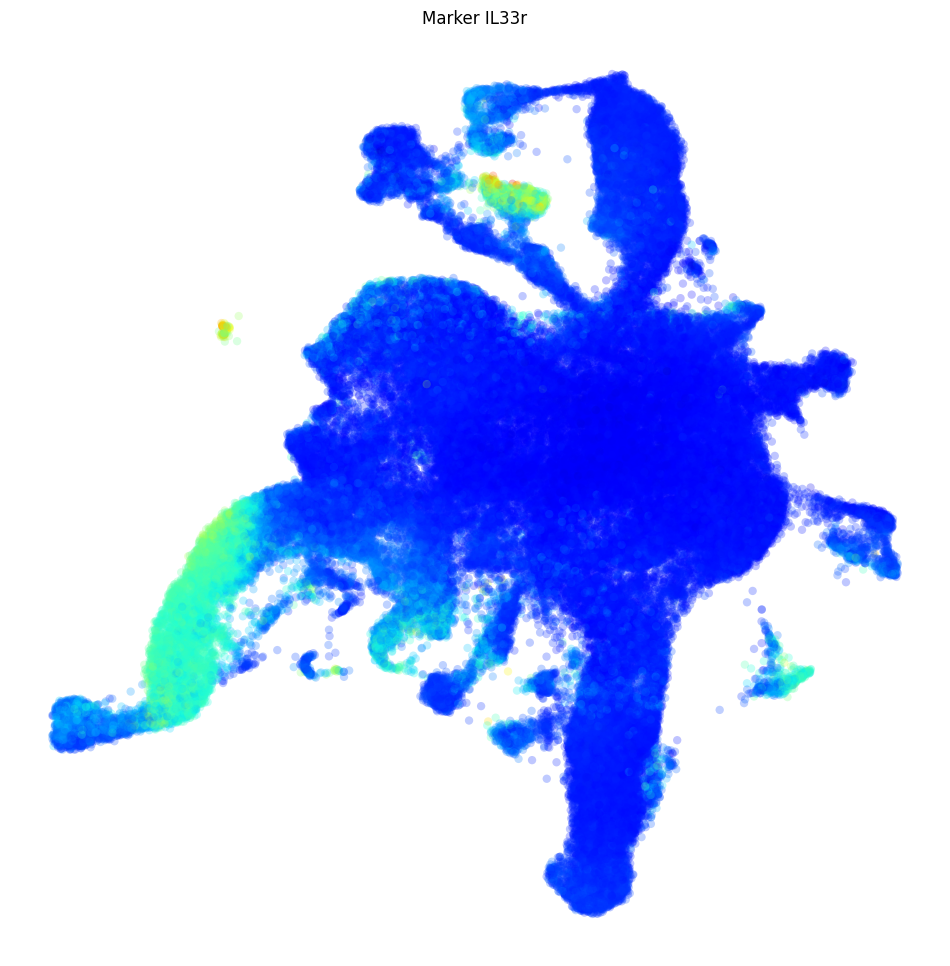

In [58]:
# tmp_marker = "IL33r"

# plt.close("all")
# fig, ax = plt.subplots(figsize=(12,12))

# ax.scatter(\
#     tmp_fcs.obs.loc[sampled_cells, 'umap-x'], 
#     tmp_fcs.obs.loc[sampled_cells, 'umap-y'],
#     c=tmp_fcs[sampled_cells, tmp_marker].X.toarray().reshape(-1),
#     cmap="jet",
#     # color="purple",
#     edgecolors='none', 
#     alpha=0.25)


# # ax.set_xlim(umap_bounds.iloc[0,:].values)
# # ax.set_ylim(umap_bounds.iloc[1,:].values)
# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)
# ax.spines.bottom.set_visible(False)
# ax.spines.left.set_visible(False)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.title("Marker {}".format(tmp_marker))